In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [39]:
## random seed
torch.seed()
np.random.seed()

In [ ]:
## hyperparameter

## dataset
negative_interval = [-200, 200]
positive_interval = [0, 1]


# loss
loss_margin = 0.2

## architecture
mode = 'fast' # ['fast', 'accurate']


kernel_size = (11,11)
in_channels = 
out_channels = 
in_features = 
out_features = 
patch_size = (64, 64)



In [2]:
## dataloader

In [1]:
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
from mc_cnn.run import run_mc_cnn_fast, run_mc_cnn_accurate
from mc_cnn.weights import get_weights
import rasterio

left_imgpath = 'data/chess1/im0.png'
right_imgpath = 'data/chess1/im1.png'

disparity_min = 75
disparity_max = 262

# Read images (only grayscale images are accepted )
left_image = rasterio.open(left_imgpath).read(1)
right_image = rasterio.open(right_imgpath).read(1)

# Path to the pretrained network
mccnn_fast_model_path = str(get_weights(arch="fast", training_dataset="middlebury")) # Or custom weights filepath
mccnn_accurate_model_path = str(get_weights(arch="accurate", training_dataset="middlebury")) # Or custom weights filepath

# Cost volume using mccnn fast similarity measure
cost_volume_fast = run_mc_cnn_fast(left_image, right_image, disparity_min, disparity_max, mccnn_fast_model_path)

# Cost volume using mccnn accurate similarity measure
# cost_volume_accurate = run_mc_cnn_accurate(left_image, right_image, disparity_min, disparity_max, mccnn_accurate_model_path)



C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


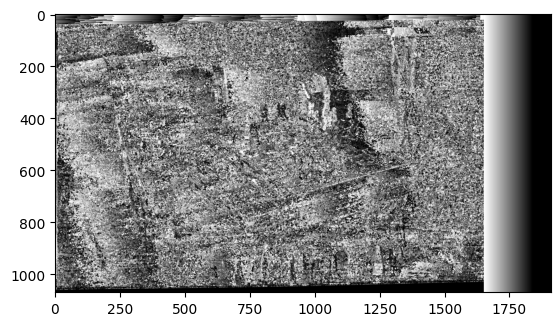

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# fast_disparity_map = np.argmin(cost_volume_fast, axis = 2)
plt.imshow(fast_disparity_map, 'gray')

In [70]:
## model

class FastModel(nn.Module) :
    def __init__(self, in_channels, out_channels, kernel_size, ) :
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(
                in_channels = self.in_channels, 
                out_channels = self.out_channels, 
                kernel_size = self.kernel_size
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = self.out_channels, 
                out_channels = self.out_channels, 
                kernel_size = self.kernel_size
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = self.out_channels, 
                out_channels = self.out_channels, 
                kernel_size = self.kernel_size
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = self.out_channels, 
                out_channels = self.out_channels, 
                kernel_size = self.kernel_size
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = self.out_channels, 
                out_channels = self.out_channels, 
                kernel_size = self.kernel_size
            ),
        )


    def forward(self, x, positive = None, negative = None) :
        if self.training :
            left = self.conv_blocks(x)
            left = F.normalize(left, p = 2, dim = 1)

            pos_output = self.conv_blocks(positive)
            pos_output = F.normalize(pos_output, p = 2, dim = 1)

            neg_output = self.conv_blocks(negative)
            neg_output = F.normalize(neg_output, p = 2, dim = 1)

            return left, pos_output, neg_output

        else : # eval 모드
            assert positive is None and negative is None, 'only take inference image in eval mode'
            features = self.conv_blocks(x)
            features = F.normalize(features, p = 2, dim = 1)
            return features





class AccurateModel(nn.Module) :
    def __init__(self, in_channels, out_channels, kernel_size, in_features, mid_features) :
        '''
        in_channels : input channel of image
        out_channels : same along the conv_blocks
        in_features : input dim of linear layer to calculate similarity
        mid_features : Same along the linear_blocks
        '''
        super().__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = kernel_size
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = out_channels,
                out_channels = out_channels,
                kernel_size = kernel_size
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = out_channels,
                out_channels = out_channels,
                kernel_size = kernel_size
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = out_channels,
                out_channels = out_channels,
                kernel_size = kernel_size
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = out_channels,
                out_channels = out_channels,
                kernel_size = kernel_size
            ),
            nn.ReLU(),
        )

        # compute similarity score
        self.linear_blocks = nn.Sequential(
            nn.Linear(in_features = in_features, out_features = mid_features),
            nn.ReLU(),
            nn.Linear(in_features = mid_features, out_features = mid_features),
            nn.ReLU(),
            nn.Linear(in_features = mid_features, out_features = mid_features),
            nn.ReLU(),
            nn.Linear(in_features = mid_features, out_features = 1),
            nn.Sigmoid(),
        )


    def forward(self, x, positive, negative) :
        if self.training :
            left = self.conv_blocks(x) # (Bx112x1x1)
            pos_output = self.conv_blocks(positive)
            neg_output = self.conv_blocks(negative)
            
            # calculate similarity
            pos_output = torch.cat([left, pos_output], dim = 1)
            pos_output = torch.squeeze(pos_output)
            pos_output = self.linear_blocks(pos_output)

            neg_output = torch.cat([left, neg_output], dim = 1)
            neg_output = torch.squeeze(neg_output)
            neg_output = self.linear_blocks(neg_output)

            return pos_output, neg_output

        else :
            assert positive is None and negative is None, 'only take inference image in eval mode'

In [61]:
## loss
class HingeLoss(nn.Module) :
    def __init__(self, margin) :
        super().__init__()
        self.margin = margin

    def forward(self, pos_output, neg_output) :
        return torch.max(torch.Tensor([0]), self.margin + neg_output - pos_output).mean()

BCELoss = nn.BCELoss()


In [71]:
accmodel = AccurateModel(in_channels = 1, out_channels = 112, kernel_size = 3, in_features = 224, mid_features = 384)

In [82]:
left = torch.randn((B, 1, 11, 11))
pos = torch.randn((B, 1, 11, 11))
neg = torch.randn((B, 1, 11, 11))

pos_output, neg_output = accmodel(left, pos, neg)

BCELoss(pos_output, torch.tensor([[1],[1],[1],[1],[1],[1],[1],[1]], dtype = torch.float32))

tensor(0.7073, grad_fn=<BinaryCrossEntropyBackward0>)

In [36]:
## DataLoader

tensor(0.7096)

In [41]:
class Dataset

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\user/.cache\torch\hub\v0.10.0.zip


In [6]:
    from mc_cnn.run import run_mc_cnn_fast, run_mc_cnn_accurate
    from mc_cnn.weights import get_weights
    import rasterio


    if __name__ == '__main__':

        # Read images (only grayscale images are accepted )
        left_image = rasterio.open('Path_to_left_image').read(1)
        right_image = rasterio.open('Path_to_right_image').read(1)

        # Path to the pretrained network
        mccnn_fast_model_path = str(get_weights(arch="fast", training_dataset="middlebury")) # Or custom weights filepath
        mccnn_accurate_model_path = str(get_weights(arch="accurate", training_dataset="middlebury")) # Or custom weights filepath

        # Cost volume using mccnn fast similarity measure
        cost_volume_fast = run_mc_cnn_fast(left_image, right_image, disparity_min, disparity_max, mccnn_fast_model_path)
        # Cost volume using mccnn accurate similarity measure
        cost_volume_accurate = run_mc_cnn_accurate(left_image, right_image, disparity_min, disparity_max, mccnn_accurate_model_path)



ModuleNotFoundError: No module named 'mc_cnn'